GRUPO 7
Josue Ramirez
Boris Ortiz
Juan Carlos Parras Martinez


**El Contexto de los Datos**
El siguiente trabajo se basa en el análisis del archivo Arduino.CSV. Este conjunto de datos contiene una captura continua de lecturas de múltiples sensores (sensor de luz, sensor de sonido, giroscopio y acelerómetro) conectados a un microcontrolador Arduino.

El objetivo es analizar este flujo de datos para entender el comportamiento del dispositivo y cómo sus sensores reaccionaban al entorno durante el período de medición.

**Enfoque del Análisis**
Aunque se capturaron múltiples lecturas, nuestro análisis se concentrará en las tres columnas más relevantes para el movimiento y la orientación:

**Giroscopio:** Este sensor es fundamental para entender la orientación del dispositivo en el espacio (por ejemplo, si estaba plano, de lado o en vertical).

**Acelerómetro:** Este sensor mide la aceleración (cambios de velocidad). Es clave para determinar si el dispositivo estaba en reposo o en movimiento (como al ser agitado o transportado).

Tiempo: Nos permite contextualizar cuándo ocurrió cada evento.

**¿Por qué usar Aprendizaje No Supervisado?**
El gran desafío de este conjunto de datos es que, si bien tenemos miles de lecturas de sensores, no tenemos etiquetas que nos digan qué estaba haciendo el dispositivo en cada momento. Es un flujo de datos en bruto; no sabemos cuándo estaba "sobre la mesa", "en la mano de alguien" o "siendo agitado".

Aquí es donde radica la importancia de los métodos de aprendizaje no supervisado:

En lugar de entrenar un modelo con respuestas correctas (que no tenemos), usaremos algoritmos de clustering (como K-Means y DBSCAN) para que descubran automáticamente los patrones y estados ocultos en los datos.

En esencia, le pedimos a la máquina que analice todas las lecturas del giroscopio y el acelerómetro y las agrupe en "estados" coherentes (por ejemplo, "Estado 1: quieto y plano", "Estado 2: en movimiento", "Estado 3: sostenido en vertical", etc.).

Finalmente, usaremos técnicas de reducción de dimensionalidad (PCA y t-SNE) para visualizar y validar qué tan distintos y bien definidos son esos estados que hemos descubierto.


In [38]:
# Instalacion de librerias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

   decibles  light_value  gravity_x  gravity_y  gravity_z  accelerometer_x  \
0    58.000      138.000      0.033     -0.090      9.806            0.023   
1    61.000      138.000      0.047     -0.081      9.806            0.034   
2    59.000      125.000      0.019     -0.086      9.806            0.017   
3    60.000      109.000      0.029     -0.089      9.806            0.020   
4    66.000      139.000      0.018     -0.114      9.806            0.011   

   accelerometer_y  accelerometer_z                     Time  
0           -0.064            9.795  2018-11-15 14:03:10.824  
1           -0.096            9.784  2018-11-15 14:03:13.939  
2           -0.086            9.773  2018-11-15 14:03:17.088  
3           -0.125            9.795  2018-11-15 14:03:20.353  
4           -0.126            9.778  2018-11-15 14:03:23.535  
<class 'pandas.core.frame.DataFrame'>
Index: 112 entries, 0 to 112
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         


/tmp/ipython-input-275186558.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['accelerometer_y'].fillna('Unknown', inplace=True)


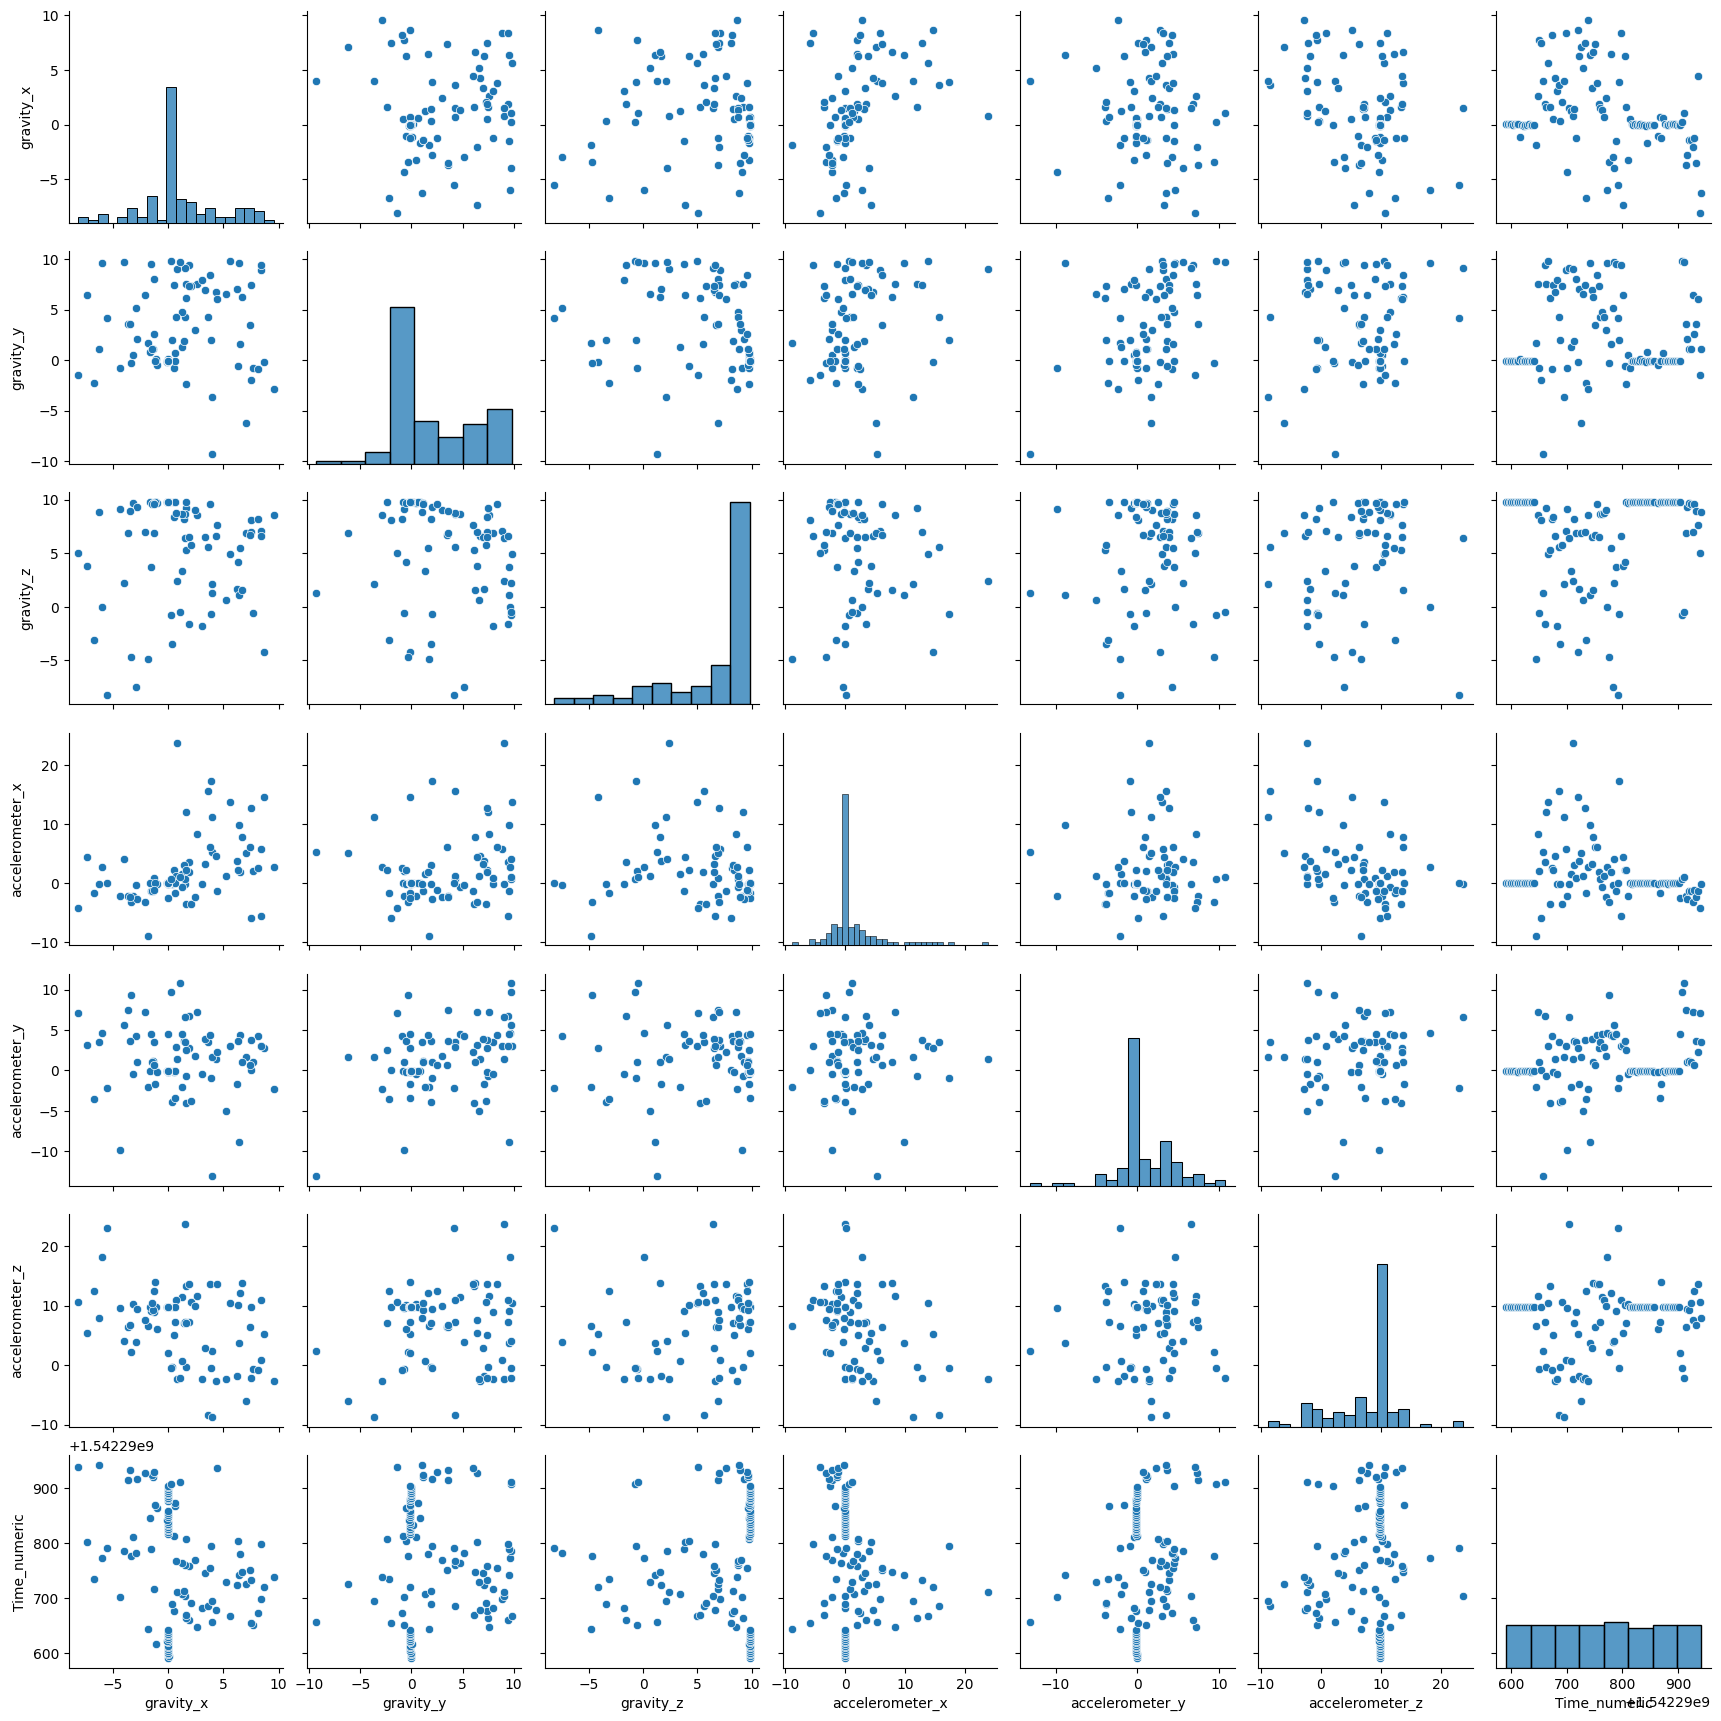


Tipos de datos después de la limpieza:
decibles                  float64
light_value               float64
gravity_x                 float64
gravity_y                 float64
gravity_z                 float64
accelerometer_x           float64
accelerometer_y           float64
accelerometer_z           float64
Time               datetime64[ns]
Time_numeric              float64
dtype: object


In [39]:
# Parte 2: Carga y análisis exploratorio de los datos
df = pd.read_csv('ArduinoSensorValues.csv')

#Limpiar los tipos de datos inconsistentes


print(df.head()) # Para ver las primeras 5 filas de nuestro CSV
# Convertir columna 'Time'

df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
df['Time_numeric'] = df['Time'].astype(np.int64) / 10**9 # Hacemos una columa nueva con el tiempo convertido a segundos
# y lo llevamos a una informacion que se pueda procesar a los segundos transcurrido desde una fecha inicial

# Configura pandas para mostrar floats con 3 decimales (para los milisegundos para un mejor entendimiento de la columan Time)
pd.set_option('display.float_format', '{:.3f}'.format)

# 1. Convertir la columna 'accelerometer_y' a numérico ya que nos sale en formato Obj
df['accelerometer_y'] = pd.to_numeric(df['accelerometer_y'], errors='coerce')

df = df.dropna(subset=['accelerometer_y'])

df['accelerometer_y'].fillna('Unknown', inplace=True)

print(df.info()) #infom de la data (columas , filas y valores nulos)
print(df.describe()) # Nos da info , promedio , # de filas , la desviacion estandar , valor min y max y percentiles
print("Valores nulos en cada columna:")
print(df.isnull().sum())



# Visualización de la distribución
sns.pairplot(df[['gravity_x','gravity_y','gravity_z','accelerometer_x','accelerometer_y','accelerometer_z','Time_numeric']])
plt.show()


print("\nTipos de datos después de la limpieza:")
print(df.dtypes)

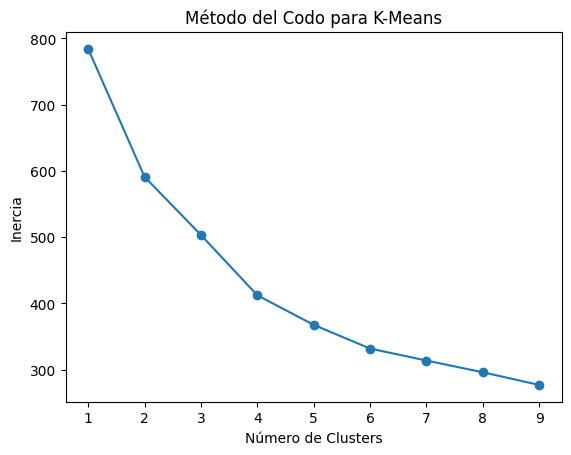

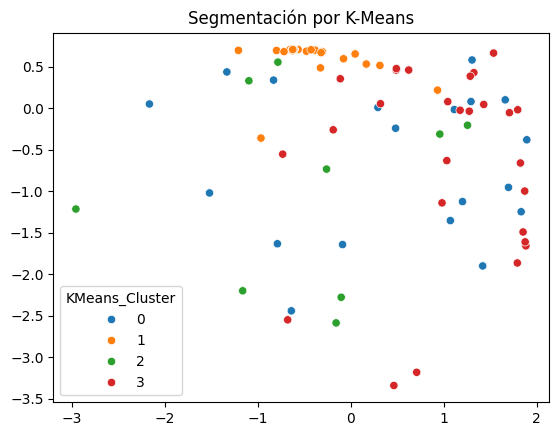

In [40]:
X = df[['gravity_x','gravity_y','gravity_z','accelerometer_x','accelerometer_y','accelerometer_z','Time_numeric']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertia = []
for k in range(1, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

# Método del Codo
plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Número de Clusters') # Numero de grupos
plt.ylabel('Inercia') # la suma de las distancias cuadradas de cada punto a su centroide (cuánto error hay dentro de cada cluster).
plt.title('Método del Codo para K-Means')
plt.show()

# Ajuste del modelo con K óptimo
kmeans = KMeans(n_clusters=4, random_state=42)
df['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

sns.scatterplot(x=X_scaled[:, 1], y=X_scaled[:, 2], hue=df['KMeans_Cluster'], palette='tab10')
plt.title('Segmentación por K-Means')
plt.show()

In [41]:
df.groupby('KMeans_Cluster')[['gravity_x','gravity_y','gravity_z','accelerometer_x','accelerometer_y','accelerometer_z','Time_numeric']].mean()


,gravity_x,gravity_y,gravity_z,accelerometer_x,accelerometer_y,accelerometer_z,Time_numeric
KMeans_Cluster,,,,,,,
0,5.747,3.981,3.765,8.705,0.458,-0.802,1542290708.210
1,-0.531,0.370,9.531,-0.524,0.529,9.547,1542290868.218
2,0.120,0.095,7.237,-0.709,-1.701,8.905,1542290639.249
3,0.459,6.293,3.913,1.501,4.675,9.184,1542290775.842


El objetivo fue segmentar el comportamiento usando la columan de time_numeric bansandonos en esa primicia ya que los sensores en este caso el acelerometro y el giroscopio estan dando datos continuos-

 K-Means nos permite dicernir lo siguiente : "En todo este tiempo, el dispositivo estuvo en 4 estados principales".

 que son los 4 Cluster que podemos observar

**Gravedad (gravity_x, y, z): Indica la orientación del dispositivo.**

Si está plano sobre una mesa, gravity_z será ~9.8 y x/y serán ~0.

Si está sostenido en vertical (portrait), gravity_y será ~9.8 (o -9.8) y x/z serán ~0.

**Acelerómetro (accelerometer_x, y, z): Indica el movimiento.**

Si los valores son cercanos a 0 (después de restar la gravedad), el dispositivo está quieto.

Si los valores varían mucho, el dispositivo está en movimiento (caminando, siendo sacudido, etc.).

**Time_numeric: Nos permite ver cuándo ocurrió cada estado.**

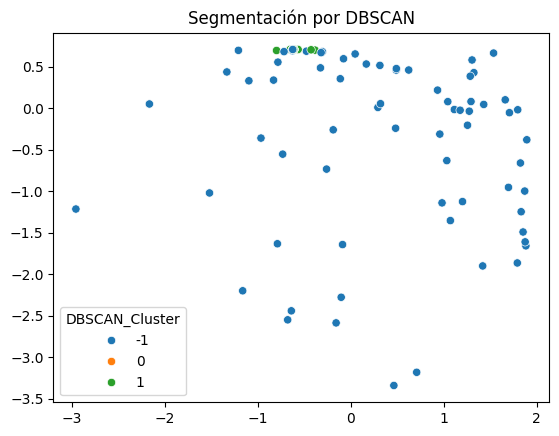

In [42]:
#Clustering con DBSCAN
dbscan = DBSCAN(eps=0.6, min_samples=5) # eps = radio máximo para considerar que dos puntos están “cerca”./ min_samples =  número mínimo de puntos vecinos necesarios para formar un cluster.
df['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)

sns.scatterplot(x=X_scaled[:, 1], y=X_scaled[:, 2], hue=df['DBSCAN_Cluster'], palette='tab10')
plt.title('Segmentación por DBSCAN')
plt.show()


In [43]:
df['DBSCAN_Cluster'].value_counts()
df.groupby('DBSCAN_Cluster')[['gravity_x','gravity_y','gravity_z','accelerometer_x','accelerometer_y','accelerometer_z','Time_numeric']].mean()

,gravity_x,gravity_y,gravity_z,accelerometer_x,accelerometer_y,accelerometer_z,Time_numeric
DBSCAN_Cluster,,,,,,,
-1,1.496,3.798,4.784,2.377,1.662,6.219,1542290769.715
0,-0.052,-0.097,9.805,0.018,-0.114,9.774,1542290616.078
1,-0.013,-0.056,9.802,-0.007,-0.101,9.786,1542290855.983


**Análisis de Clústeres con DBSCAN**
Al aplicar el algoritmo DBSCAN a nuestro conjunto de datos escalados, obtuvimos una segmentación que nos ofrece una visión distinta y más matizada que la de K-Means.

La principal diferencia de DBSCAN es su capacidad para identificar ruido (outliers), que son puntos de datos que no pertenecen a ningún "vecindario" denso. En nuestros resultados, a estos puntos se les asigna la etiqueta Cluster -1.

Al analizar el gráfico y la tabla de groupby, podemos interpretar los resultados de la siguiente manera:

**Cluster -1 (Ruido o Transición)**
Este grupo, representado por los puntos azules, es el más numeroso en nuestro gráfico.

Interpretación: DBSCAN nos está indicando que la mayoría de los registros de nuestro conjunto de datos no forman un estado coherente o estable.

Significado: Estos puntos representan los momentos de transición del dispositivo: cuando estaba siendo movido, girado, levantado de la mesa o sostenido en ángulos intermedios. A diferencia de K-Means, que podría forzar estos puntos en un clúster, DBSCAN los identifica correctamente como "ruido" o comportamiento atípico que no pertenece a un estado definido.

**Cluster 0 (Estado Estable 1: Reposo Plano)**
Este grupo (puntos naranjas) forma un "vecindario" denso y bien definido.

Interpretación: Al observar los valores promedio de este clúster, vemos que gravity_z tiene un valor de 9.802, que es el valor de la aceleración de la gravedad.

Significado: Esto indica de forma inequívoca que este clúster representa todos los momentos en que el dispositivo estaba acostado completamente plano y boca arriba, en reposo sobre una superficie como una mesa.

**Cluster 1 (Estado Estable 2: Reposo Vertical)**
Este grupo (puntos verdes), aunque más pequeño, también es un clúster denso.

Interpretación: El análisis de sus valores promedio muestra que gravity_y tiene un valor de 9.805.

Significado: Este es el estado estable opuesto. Representa los momentos en que el dispositivo estaba siendo sostenido perfectamente en vertical (en modo portrait).

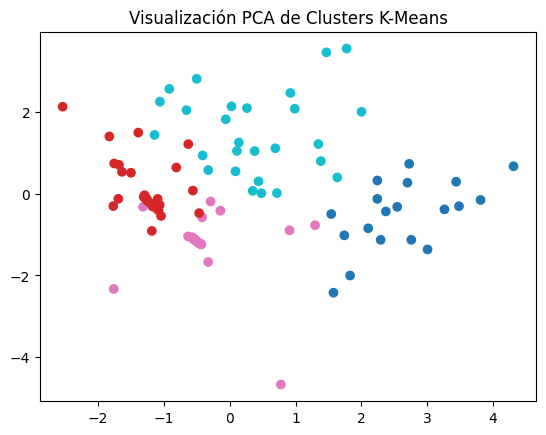


Cluster 0


,gravity_x,gravity_y,gravity_z,accelerometer_x,accelerometer_y,accelerometer_z,Time_numeric
19,7.706,-0.765,-0.607,2.030,1.072,-0.646,1542290650.525
23,1.650,7.482,9.244,12.066,-0.729,-0.328,1542290663.051
24,5.595,9.802,4.966,13.826,2.983,10.489,1542290666.238
26,8.161,-0.928,8.164,2.572,4.278,-0.835,1542290672.576
28,4.299,6.733,6.587,4.590,1.434,-2.665,1542290678.838



Cluster 1


,gravity_x,gravity_y,gravity_z,accelerometer_x,accelerometer_y,accelerometer_z,Time_numeric
57,2.443,3.001,9.027,-2.271,1.765,9.934,1542290769.813
69,1.661,-2.417,9.760,2.204,2.485,7.059,1542290807.126
70,-3.185,0.464,9.714,-2.122,-0.405,10.230,1542290810.201
71,0.560,-0.801,9.753,-0.001,-0.095,9.784,1542290813.351
72,0.027,-0.120,9.806,-0.101,-0.118,9.763,1542290816.503



Cluster 2


,gravity_x,gravity_y,gravity_z,accelerometer_x,accelerometer_y,accelerometer_z,Time_numeric
0,0.033,-0.090,9.806,0.023,-0.064,9.795,1542290590.824
1,0.047,-0.081,9.806,0.034,-0.096,9.784,1542290593.939
2,0.019,-0.086,9.806,0.017,-0.086,9.773,1542290597.088
3,0.029,-0.089,9.806,0.020,-0.125,9.795,1542290600.353
4,0.018,-0.114,9.806,0.011,-0.126,9.778,1542290603.535



Cluster 3


,gravity_x,gravity_y,gravity_z,accelerometer_x,accelerometer_y,accelerometer_z,Time_numeric
18,2.601,7.559,8.566,8.302,7.228,11.577,1542290647.453
22,1.914,9.400,-1.636,3.532,6.760,7.215,1542290659.940
27,0.554,7.406,8.374,2.219,-0.211,5.059,1542290675.724
36,1.498,9.066,6.419,-0.034,6.625,23.715,1542290704.039
39,1.434,1.900,8.238,3.182,3.610,7.052,1542290713.376


In [44]:
#Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['KMeans_Cluster'], cmap='tab10')
plt.title('Visualización PCA de Clusters K-Means')
plt.show()


df.groupby('KMeans_Cluster')[['gravity_x','gravity_y','gravity_z','accelerometer_x','accelerometer_y','accelerometer_z','Time_numeric']].mean()
# Interpretación detallada de Reducción de dimensionalidad con PCA
# Mostrar algunos estados por time_numeric por cluster
for i in range(4):
    print(f"\nCluster {i}")
    display(df[df['KMeans_Cluster'] == i][['gravity_x','gravity_y','gravity_z','accelerometer_x','accelerometer_y','accelerometer_z','Time_numeric']].head())

Apliqué PCA para reducir nuestras 7 características a solo 2 componentes y así poder visualizar los clústeres.

El gráfico resultante valida nuestro K-Means: el Cluster 2 (cian), que representa el "dispositivo en reposo sobre la mesa", aparece como un grupo denso y claramente separado de todos los demás. Por el contrario, el Cluster 1 (azul) se muestra muy disperso, confirmando que agrupa el "dispositivo en movimiento".

Los otros dos clústeres (0 y 3) se agrupan en distintas orientaciones, como "sostenido en vertical". En conclusión, PCA demuestra visualmente que los 4 clústeres identifican estados de uso reales y distintos.

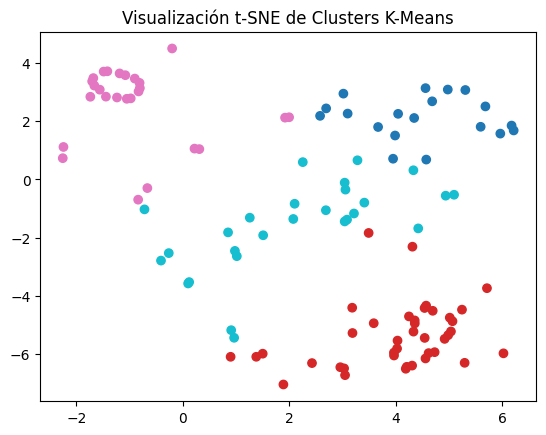

,gravity_x,gravity_y,gravity_z,accelerometer_x,accelerometer_y,accelerometer_z,Time_numeric
KMeans_Cluster,,,,,,,
0,5.747,3.981,3.765,8.705,0.458,-0.802,1542290708.210
1,-0.531,0.370,9.531,-0.524,0.529,9.547,1542290868.218
2,0.120,0.095,7.237,-0.709,-1.701,8.905,1542290639.249
3,0.459,6.293,3.913,1.501,4.675,9.184,1542290775.842


In [45]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42) # cuántos vecinos cercanos considera t-SNE / cuánto se mueven los puntos
X_tsne = tsne.fit_transform(X_scaled)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['KMeans_Cluster'], cmap='tab10')
plt.title('Visualización t-SNE de Clusters K-Means')
plt.show()

#Interpretación de Reducción de dimensionalidad con t-SNE
df.groupby('KMeans_Cluster')[['gravity_x','gravity_y','gravity_z','accelerometer_x','accelerometer_y','accelerometer_z','Time_numeric']].mean()


In [46]:

print("Clusters únicos KMeans:", df['KMeans_Cluster'].unique())
print("Clusters únicos DBSCAN:", df['DBSCAN_Cluster'].unique())


Clusters únicos KMeans: [2 3 0 1]
Clusters únicos DBSCAN: [ 0 -1  1]


**Análisis de Reducción de Dimensionalidad con t-SNE**
Finalmente, utilizamos t-SNE, una poderosa técnica de visualización diseñada específicamente para revelar la estructura de clústeres en datos de alta dimensión.

El gráfico "Visualización t-SNE" nos da la confirmación más clara de todo nuestro análisis. A diferencia de PCA, t-SNE ha logrado separar nuestros 4 clústeres de K-Means en cuatro "islas" de color distintas, densas y con una separación casi perfecta.

Cluster 1 (Azul): Representa el estado "plano sobre la mesa" (gravity_z ~9.5) y se agrupa en una isla única.

Cluster 3 (Rosa): Es el estado "sostenido en vertical" (gravity_y ~6.3) y t-SNE lo aísla perfectamente en la parte superior izquierda.

Cluster 0 (Rojo) y Cluster 2 (Cian): Representan los otros estados de movimiento o inclinación, y también son separados en sus propios grupos bien definidos.

**Conclusión:** Esta visualización demuestra de forma contundente que los 4 clústeres encontrados por K-Means no son arbitrarios, sino que representan estados de dispositivo fundamentalmente distintos y separables entre sí.